# Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
files = [
    "../data/datatest.txt",
    "../data/datatest2.txt",
    "../data/datatraining.txt"
]

dfs = []

for file in files:
    df = pd.read_csv(file, index_col=[0])
    dfs.append(df)

In [36]:
df = pd.concat(dfs, ignore_index=True)

# Data view

In [37]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [38]:
df.tail()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
20555,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
20556,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
20557,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
20558,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1
20559,2015-02-10 09:33:00,21.10,36.2000,447.0,821.000000,0.005612,1


In [39]:
# Target counts
df[["Occupancy"]].value_counts()

Occupancy
0            15029
1             5531
Name: count, dtype: int64

In [40]:
# Target counts as percentages
df[["Occupancy"]].value_counts()*100/df[["Occupancy"]].value_counts().sum()

Occupancy
0            73.098249
1            26.901751
Name: count, dtype: float64

**Moderate class imbalance present. Need to be addressed later**

In [41]:
# Summary information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


**No nulls present. Hence no imputation needed.**

In [42]:
# data summary statistics
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.269018
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.443460
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,1.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


In [43]:
# Checking for null/nan
df.isna().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

**No null values**

In [44]:
# Checking for inf
np.isinf(df.drop(columns=["date"])).sum() # date (object type) not supported by numpy

Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

**No +/- inf values**

In [45]:
# Data types
df.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

# Exploratory Data Analysis (EDA)

## Histograms

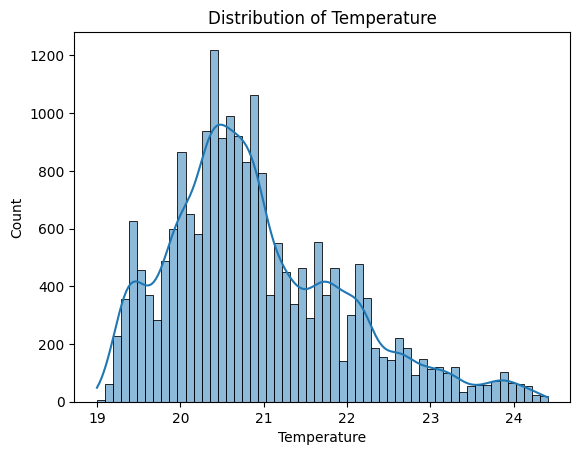

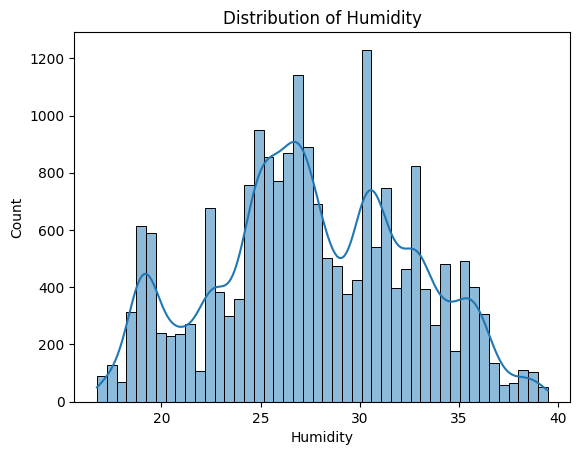

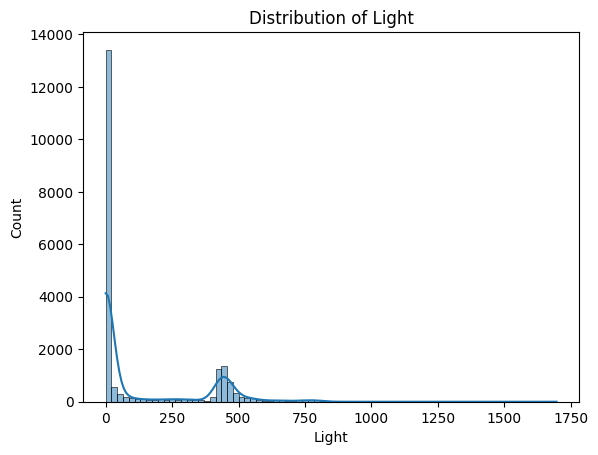

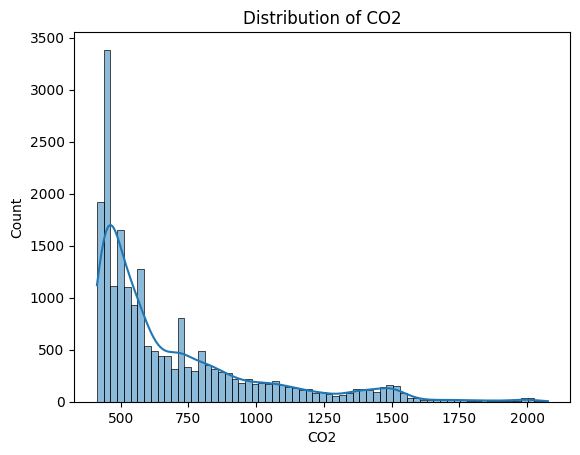

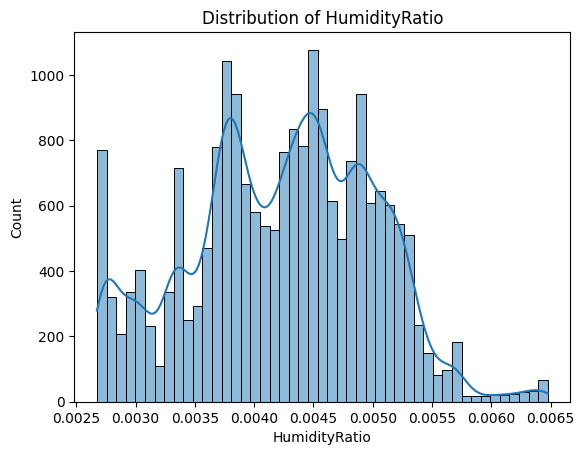

In [46]:
for col in ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

## Relationships

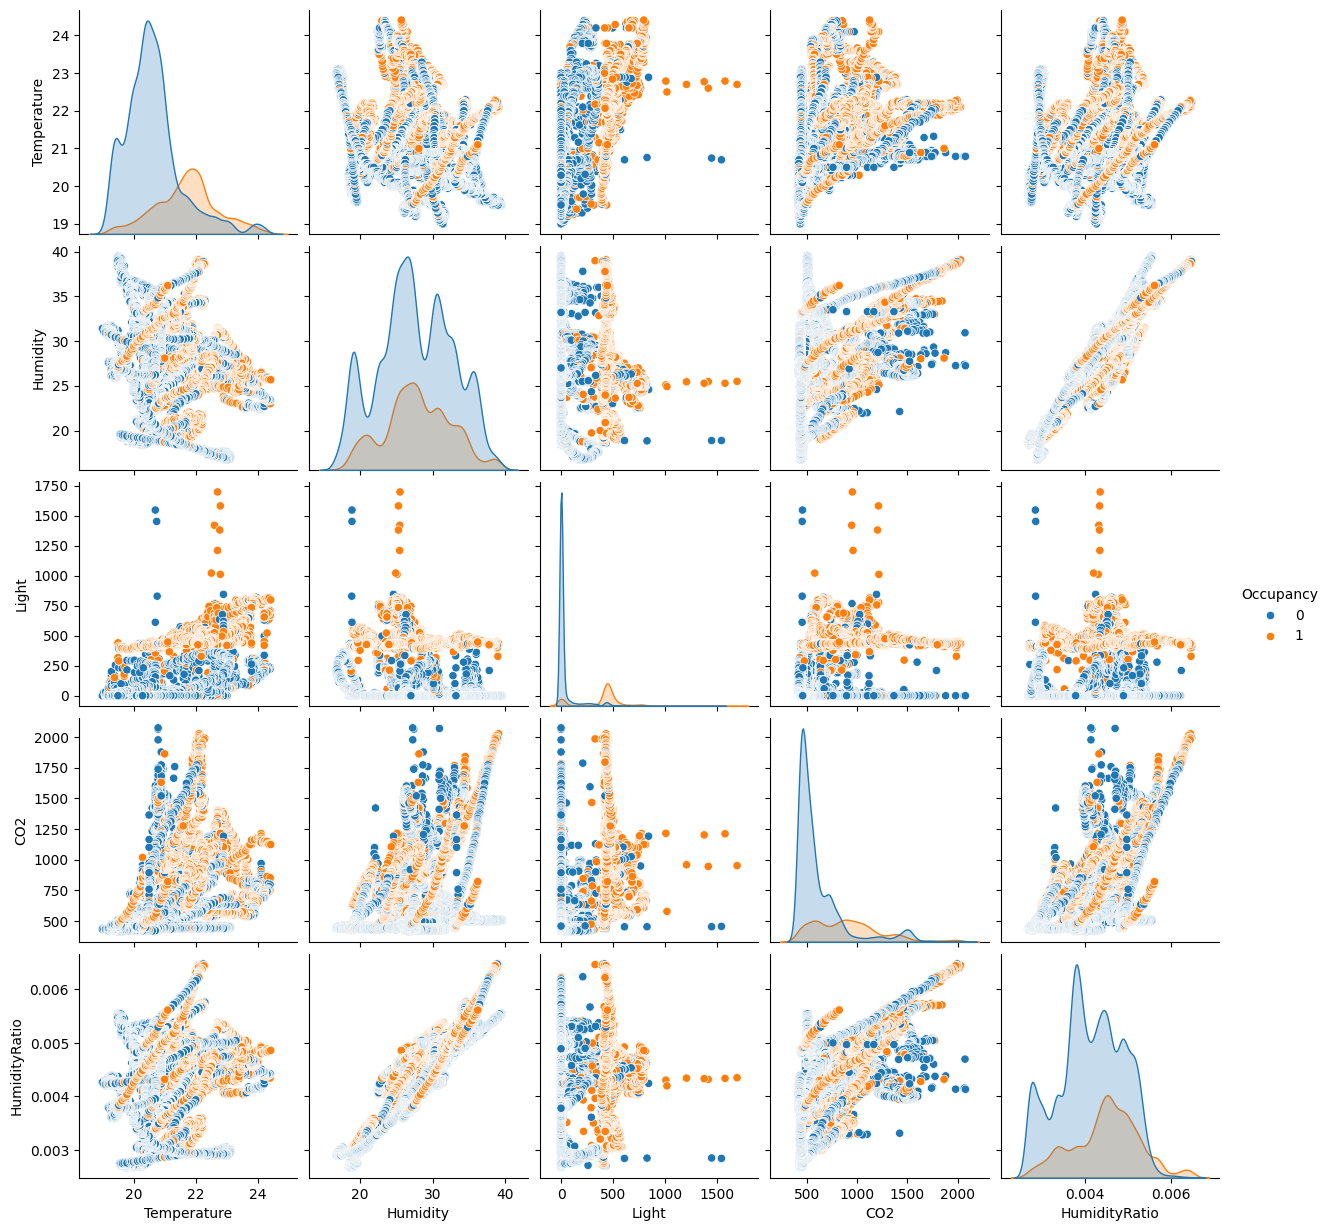

In [47]:
# pair relationships between features
sns.pairplot(df, hue='Occupancy', diag_kind='kde')
plt.show()

**Except with 'Light', features don't have significant pairwise relationships with each other**

## Correlations

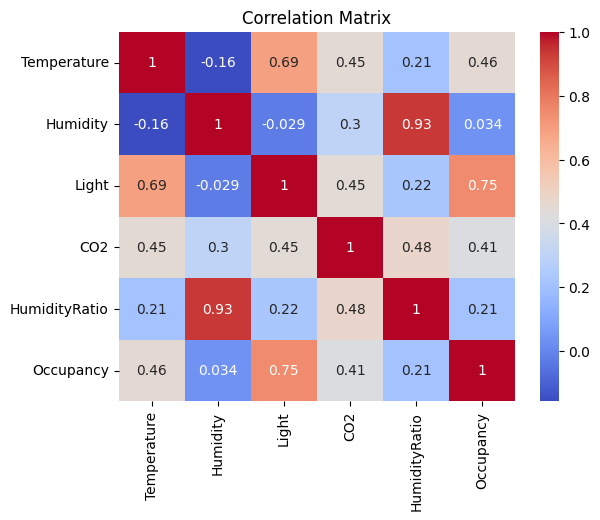

In [48]:
# Compute correlation
correlation_matrix = df.drop(columns=["date"]).corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Outlier Detection

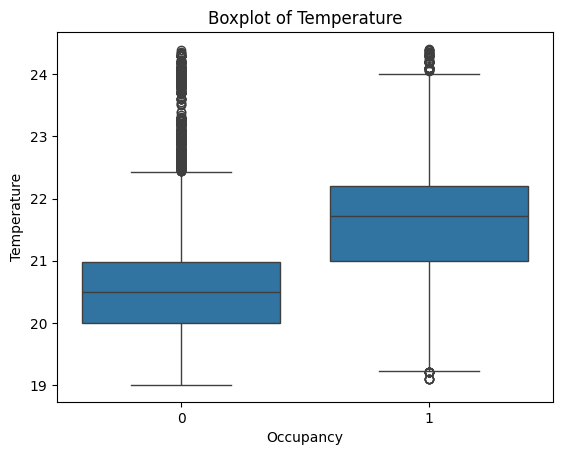

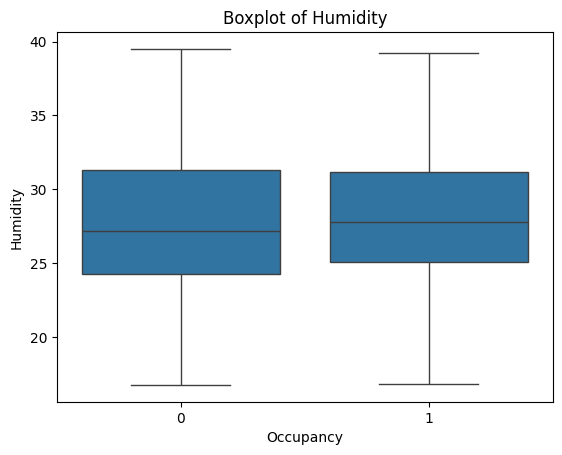

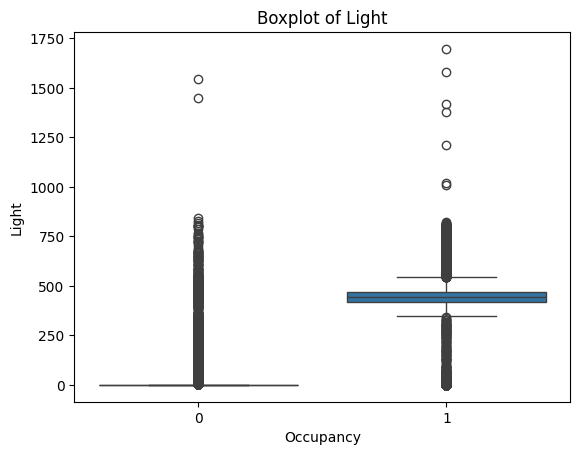

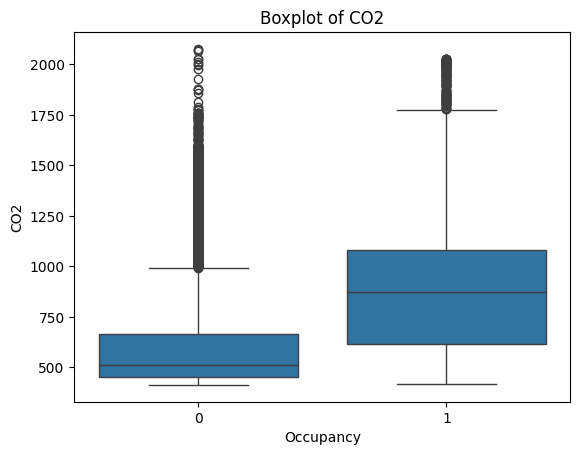

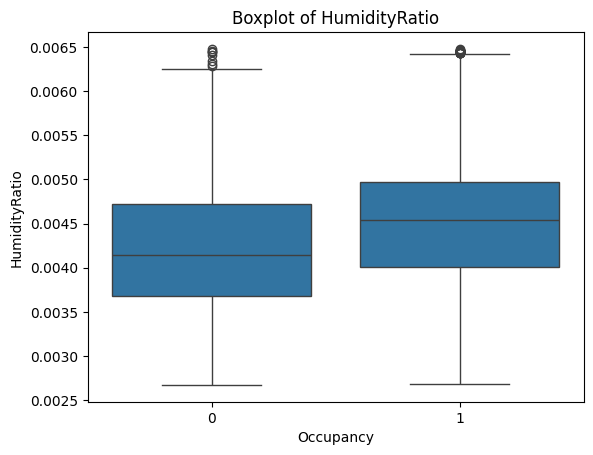

In [49]:
for column in ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']:
    sns.boxplot(data=df, x="Occupancy", y=column)
    plt.title(f'Boxplot of {column}')
    plt.show()

**Notes:**
1. Temperature outliers happens due to imbalance. Fix -> balance classes
2. Light is bimodal with highly leptokurtic nature. Fix -> Discretize w/ 2 bins
3. CO2 is highly right skewed. Fix -> Boxcox transform
4. HumidityRatio outliers happens due to imbalance. Fix -> option 1. 

# Data preprocessing

## Date adjustments

In [50]:
df["datetime"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S")
print(df.head())
df.dtypes

                  date  Temperature  Humidity       Light         CO2  \
0  2015-02-02 14:19:00      23.7000    26.272  585.200000  749.200000   
1  2015-02-02 14:19:59      23.7180    26.290  578.400000  760.400000   
2  2015-02-02 14:21:00      23.7300    26.230  572.666667  769.666667   
3  2015-02-02 14:22:00      23.7225    26.125  493.750000  774.750000   
4  2015-02-02 14:23:00      23.7540    26.200  488.600000  779.000000   

   HumidityRatio  Occupancy            datetime  
0       0.004764          1 2015-02-02 14:19:00  
1       0.004773          1 2015-02-02 14:19:59  
2       0.004765          1 2015-02-02 14:21:00  
3       0.004744          1 2015-02-02 14:22:00  
4       0.004767          1 2015-02-02 14:23:00  


date                     object
Temperature             float64
Humidity                float64
Light                   float64
CO2                     float64
HumidityRatio           float64
Occupancy                 int64
datetime         datetime64[ns]
dtype: object

In [51]:
df = df.sort_values(by="datetime", ascending=True, ignore_index=True)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,datetime
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,2015-02-02 14:19:00
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,2015-02-02 14:19:59
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,2015-02-02 14:21:00
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,2015-02-02 14:22:00
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,2015-02-02 14:23:00


In [52]:
df.tail()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,datetime
20555,2015-02-18 09:15:00,20.815,27.7175,429.75,1505.25,0.004213,1,2015-02-18 09:15:00
20556,2015-02-18 09:16:00,20.865,27.7450,423.50,1514.50,0.004230,1,2015-02-18 09:16:00
20557,2015-02-18 09:16:59,20.890,27.7450,423.50,1521.50,0.004237,0,2015-02-18 09:16:59
20558,2015-02-18 09:17:59,20.890,28.0225,418.75,1632.00,0.004279,1,2015-02-18 09:17:59
20559,2015-02-18 09:19:00,21.000,28.1000,409.00,1864.00,0.004321,1,2015-02-18 09:19:00


## Time Series Split

In [53]:
from sklearn.model_selection import TimeSeriesSplit
y = df["Occupancy"]
X = df.drop(columns=["date", "Occupancy"])

In [54]:
folds = 5
tscv = TimeSeriesSplit(n_splits = folds)
train_index = [] # List of index lists (i.e. = [[...], [...], ... to n folds])
test_index = []
for i, (train_index_, test_index_) in enumerate(tscv.split(X)):
    train_index.append(train_index_)
    test_index.append(test_index_)
    print(f"Fold {i}:")
    print(f"  Train: index={train_index[i]}")
    print(f"  Test:  index={test_index[i]}")

Fold 0:
  Train: index=[   0    1    2 ... 3427 3428 3429]
  Test:  index=[3430 3431 3432 ... 6853 6854 6855]
Fold 1:
  Train: index=[   0    1    2 ... 6853 6854 6855]
  Test:  index=[ 6856  6857  6858 ... 10279 10280 10281]
Fold 2:
  Train: index=[    0     1     2 ... 10279 10280 10281]
  Test:  index=[10282 10283 10284 ... 13705 13706 13707]
Fold 3:
  Train: index=[    0     1     2 ... 13705 13706 13707]
  Test:  index=[13708 13709 13710 ... 17131 17132 17133]
Fold 4:
  Train: index=[    0     1     2 ... 17131 17132 17133]
  Test:  index=[17134 17135 17136 ... 20557 20558 20559]


## Boxcox transform

In [55]:
from scipy.stats import boxcox

# Transform co2 function
def transform_co2(data, *, trained_lambda=None):
    """
    Transform to fit the best Normal curve possible
    """
    lambda_ = None
    if trained_lambda is None:
        data["CO2"], lambda_ = boxcox(data["CO2"])
    else:
        data["CO2"] = boxcox(data["CO2"], lmbda=trained_lambda)
    return (data, lambda_)

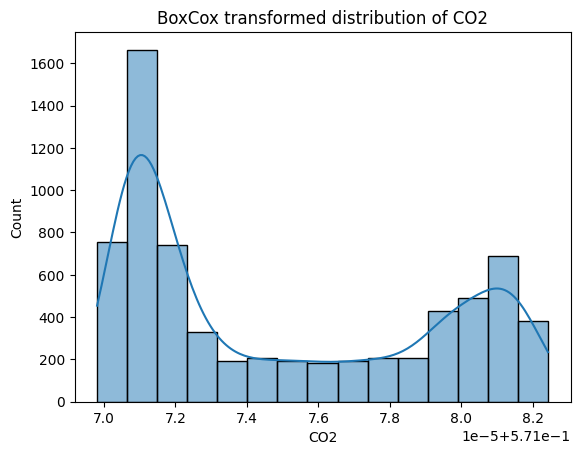

In [56]:
# Example using first fold
_fold_0_train_X, _fold_0_lambda = transform_co2(X.loc[train_index[0]])
_fold_0_test_X, _ = transform_co2(X.loc[test_index[0]], trained_lambda=_fold_0_lambda)

# Vertical joining 
_fold_0_X = pd.concat([_fold_0_train_X, _fold_0_test_X], axis=0)

# plot
sns.histplot(data=_fold_0_X["CO2"], kde=True)
plt.title("BoxCox transformed distribution of CO2")
plt.show()

## Discretize light

**Actual discretization happens at model training level in each k-fold**

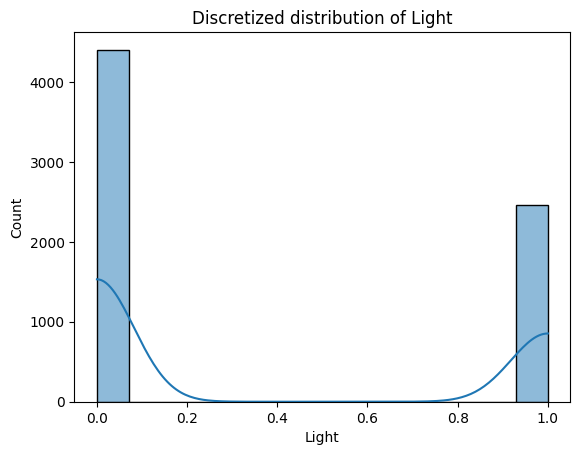

In [57]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=2, encode="ordinal",random_state= 42, strategy="kmeans")

# Example discretization
_fold_0_train_X["Light"] = discretizer.fit_transform(_fold_0_train_X["Light"].to_numpy().reshape(-1, 1))
_fold_0_test_X["Light"] = discretizer.transform(_fold_0_test_X["Light"].to_numpy().reshape(-1, 1))

# Vertical joining 
_fold_0_X = pd.concat([_fold_0_train_X, _fold_0_test_X], axis=0)

# plot
sns.histplot(data=_fold_0_X["Light"], kde=True)
plt.title("Discretized distribution of Light")
plt.show()

## Feature engineering

In [58]:
def engineer_features(data):
    """ 
    Adds the time series related features like delta, rates to dataframe.
    Removes datetime column before returning the dataframe.
    """
    # Time features
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

    # Delta (i.e. Lag) features
    data["co2_delta"] = data["CO2"] - data["CO2"].shift(1)
    data["light_delta"] = data["Light"] - data["Light"].shift(1)
    data["hr_delta"] = data["HumidityRatio"] - data["HumidityRatio"].shift(1)
    data["temp_delta"] = data["Temperature"] - data["Temperature"].shift(1)

    # Rate features
    # rate is defined as difference wrt time elapsed
    # high difference w/ high time elapsed means events are two far apart that difference in feature
    # is negligible
    data["co2_rate"] = data["co2_delta"] / (data['datetime'].diff(periods=1).dt.total_seconds()/60)
    data["light_rate"] = data["light_delta"] / (data['datetime'].diff(periods=1).dt.total_seconds()/60)
    data["hr_rate"] = data["hr_delta"] / (data['datetime'].diff(periods=1).dt.total_seconds()/60)
    data["temp_rate"] = data["temp_delta"] / (data['datetime'].diff(periods=1).dt.total_seconds()/60)

    data.drop(columns=["datetime"], inplace=True)
    data.fillna(0, inplace=True)

    return data

**Actual feature engineering happens at model training level in each k-fold**

In [59]:
# Example feature engineering
_fold_0_train_y = y.loc[train_index[0]]
_fold_0_test_y = y.loc[test_index[0]]

_fold_0_train_X = engineer_features(_fold_0_train_X)
_fold_0_test_X = engineer_features(_fold_0_test_X)

In [60]:
_fold_0_train_X.tail(10)

,Temperature,Humidity,Light,CO2,HumidityRatio,hour,day_of_week,hour_sin,hour_cos,co2_delta,light_delta,hr_delta,temp_delta,co2_rate,light_rate,hr_rate,temp_rate
3420,20.89,23.10,0.0,0.571071,0.003523,6,3,1.0,6.123234e-17,1.984458e-07,0.0,0.000000,0.00,1.951926e-07,0.0,0.000000,0.00
3421,20.89,23.10,0.0,0.571071,0.003523,6,3,1.0,6.123234e-17,-9.861899e-08,0.0,0.000000,0.00,-9.861899e-08,0.0,0.000000,0.00
3422,20.89,23.10,0.0,0.571071,0.003523,6,3,1.0,6.123234e-17,8.635699e-08,0.0,0.000000,0.00,8.635699e-08,0.0,0.000000,0.00
3423,20.89,23.10,0.0,0.571071,0.003523,6,3,1.0,6.123234e-17,-2.618587e-07,0.0,0.000000,0.00,-2.618587e-07,0.0,0.000000,0.00
3424,20.89,23.10,0.0,0.571071,0.003523,6,3,1.0,6.123234e-17,-7.637440e-08,0.0,0.000000,0.00,-7.766888e-08,0.0,0.000000,0.00
3425,20.89,23.10,0.0,0.571071,0.003523,6,3,1.0,6.123234e-17,3.827519e-08,0.0,0.000000,0.00,3.827519e-08,0.0,0.000000,0.00
3426,20.89,23.10,0.0,0.571071,0.003523,6,3,1.0,6.123234e-17,2.136009e-07,0.0,0.000000,0.00,2.100993e-07,0.0,0.000000,0.00
3427,20.89,23.00,0.0,0.571071,0.003508,6,3,1.0,6.123234e-17,9.861899e-08,0.0,-0.000015,0.00,9.861899e-08,0.0,-0.000015,0.00
3428,20.84,23.05,0.0,0.571072,0.003505,6,3,1.0,6.123234e-17,4.886278e-08,0.0,-0.000003,-0.05,4.886278e-08,0.0,-0.000003,-0.05
3429,20.89,23.10,0.0,0.571072,0.003523,6,3,1.0,6.123234e-17,0.000000e+00,0.0,0.000019,0.05,0.000000e+00,0.0,0.000019,0.05


## Oversampling

**Actual oversampling happens at model training level in each k-fold**

In [61]:
from imblearn.over_sampling import SMOTE

# Example resampling
smote = SMOTE(random_state=42)
_fold_0_train_X_resampled, _fold_0_train_y_resampled = smote.fit_resample(_fold_0_train_X, _fold_0_train_y)

### Before resampling for fold 1

In [62]:
_fold_0_train_y.value_counts()

Occupancy
0    2338
1    1092
Name: count, dtype: int64

### After resampling for fold 1

In [63]:
_fold_0_train_y_resampled.value_counts()

Occupancy
1    2338
0    2338
Name: count, dtype: int64

# Models - Training & Initial Evaluations

In [64]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import \
    classification_report, \
    roc_auc_score, \
    accuracy_score, \
    confusion_matrix
import time

## CV train-eval function

In [65]:
def train_eval(ModelClass, *, fold):
    train_X = X.loc[train_index[fold]].copy()
    train_y = y.loc[train_index[fold]].copy()
    test_X = X.loc[test_index[fold]].copy()
    test_y = y.loc[test_index[fold]].copy()

    # transform co2
    train_X, lambda_ = transform_co2(train_X)
    test_X, _ = transform_co2(test_X, trained_lambda=lambda_)

    # light discretize
    train_X["Light"] = discretizer.fit_transform(train_X["Light"].to_numpy().reshape(-1, 1))
    test_X["Light"] = discretizer.transform(test_X["Light"].to_numpy().reshape(-1, 1))

    # feature engineering
    train_X = engineer_features(train_X)
    test_X = engineer_features(test_X)

    # oversampling
    smote = SMOTE(random_state=42)
    train_X, train_y = smote.fit_resample(train_X, train_y)

    # predict and evaluate
    model = ModelClass()
    model.fit(train_X, train_y)
    start_time = time.time()
    y_pred = model.predict(test_X)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"\n======== Fold {fold} ==========\n")
    print(classification_report(test_y, y_pred))
    print(f"Inference time: {inference_time}s\n")
    print(f"Accuracy: {accuracy_score(test_y, y_pred)}\n")
    print(f"Confusion Matrix: \n{confusion_matrix(test_y, y_pred)}\n")

## Train-eval Random Forest

In [66]:
for i in range(folds):
    train_eval(RandomForestClassifier, fold=i)


======== Fold 0 ==========

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2212
           1       0.80      0.86      0.83      1214

    accuracy                           0.87      3426
   macro avg       0.86      0.87      0.86      3426
weighted avg       0.87      0.87      0.87      3426

Inference time: 0.02021312713623047s

Accuracy: 0.8718622300058377

Confusion Matrix: 
[[1948  264]
 [ 175 1039]]


======== Fold 1 ==========

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2707
           1       0.92      0.69      0.79       719

    accuracy                           0.92      3426
   macro avg       0.92      0.84      0.87      3426
weighted avg       0.92      0.92      0.92      3426

Inference time: 0.024723529815673828s

Accuracy: 0.9214827787507297

Confusion Matrix: 
[[2662   45]
 [ 224  495]]


======== Fold 2 ==========

              precision    r

## Train-eval XGBoost

In [67]:
for i in range(folds):
    train_eval(XGBClassifier, fold=i)


======== Fold 0 ==========

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2212
           1       0.82      0.84      0.83      1214

    accuracy                           0.88      3426
   macro avg       0.87      0.87      0.87      3426
weighted avg       0.88      0.88      0.88      3426

Inference time: 0.004444599151611328s

Accuracy: 0.87974314068885

Confusion Matrix: 
[[1989  223]
 [ 189 1025]]


======== Fold 1 ==========

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2707
           1       0.86      0.69      0.77       719

    accuracy                           0.91      3426
   macro avg       0.89      0.83      0.86      3426
weighted avg       0.91      0.91      0.91      3426

Inference time: 0.0037899017333984375s

Accuracy: 0.9112667834208991

Confusion Matrix: 
[[2624   83]
 [ 221  498]]


======== Fold 2 ==========

              precision    r

## Train-eval LightGBM

In [68]:
for i in range(folds):
    train_eval(LGBMClassifier, fold=i)

[LightGBM] [Info] Number of positive: 2338, number of negative: 2338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2644
[LightGBM] [Info] Number of data points in the train set: 4676, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

======== Fold 0 ==========

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2212
           1       0.77      0.87      0.81      1214

    accuracy                           0.86      3426
   macro avg       0.84      0.86      0.85      3426
weighted avg       0.87      0.86      0.86      3426

Inference time: 0.0052416324615478516s

Accuracy: 0.8598949211908932

Confusion Matrix: 
[[1895  317]
 [ 163 1051]]

[LightGBM] [Info] Number of positive: 4550, number of negative: 4550
[LightGBM] [Info] Auto

## Model selection

* Considering the accuracy metrics (accuracy, recall, precision, f1-score), all the models perform equally well (approximately).

* Hence the problem domain relies on low power devices, it is assumed that computing power will be also limited.
  
* Considering this, **LightGBM Classifier** is selected as the preferred model as it operates with lowest computing power and lowest inference time.

## Pipeline

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin

class TransformCO2(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lambda_ = None

    def fit(self, X, y=None):
        X, self.lambda_ = transform_co2(X)
        return self

    def transform(self, X):
        X, _ = transform_co2(X, trained_lambda=self.lambda_)
        return X


class DiscretizeLight(BaseEstimator, TransformerMixin):
    def __init__(self, discretizer):
        self.discretizer = discretizer

    def fit(self, X, y=None):
        self.discretizer.fit(X["Light"].to_numpy().reshape(-1, 1))
        return self

    def transform(self, X):
        X["Light"] = self.discretizer.transform(X["Light"].to_numpy().reshape(-1, 1))
        return X


class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return engineer_features(X)


In [70]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Define pipeline
pipeline = Pipeline([
    ('transform_co2', TransformCO2()),
    ('discretizer', DiscretizeLight(discretizer)),  
    ('feature_engineering', FeatureEngineer()),
    ('smote', SMOTE(random_state=42)),  # Oversampling
    ('model', LGBMClassifier())  # Example model
])


## Hyperparameter tunning

In [71]:
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameters considered
param_grid = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [5, 10],
    'model__num_leaves': [30, 60],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Tuning
grid_search.fit(X.copy(), y.copy())

# Best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Best parameters
print("\n\nBest Parameters:", best_params)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 15029, number of negative: 15029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3143
[LightGBM] [Info] Number of data points in the train set: 30058, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__num_leaves': 30}


# Model Persistence

In [72]:
import joblib
from pathlib import Path

# Create models directory if it doesn't exist
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Save the complete pipeline (includes all preprocessing + model)
model_path = models_dir / "occupancy_model_pipeline.joblib"
joblib.dump(best_model, model_path)
print(f"Model saved to: {model_path}")

# To load later for deployment:
# loaded_model = joblib.load(model_path)
# predictions = loaded_model.predict(new_data)

Model saved to: ..\models\occupancy_model_pipeline.joblib


# Evaluation

## Accuracy score & Time

In [74]:
train_X = X.loc[train_index[folds-1]].copy()
train_y = y.loc[train_index[folds-1]].copy()
test_X = X.loc[test_index[folds-1]].copy()
test_y = y.loc[test_index[folds-1]].copy()

# Train & measure training time
start_time = time.time()
best_model.fit(train_X, train_y)
training_time = time.time() - start_time

# Test & measure inference time
start_time = time.time()
y_pred = best_model.predict(test_X)
inference_time = time.time() - start_time

# Evaluation
accuracy = accuracy_score(test_y, y_pred)

print("\n")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"Final Test Accuracy: {accuracy:.4f}")

[LightGBM] [Info] Number of positive: 12783, number of negative: 12783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3140
[LightGBM] [Info] Number of data points in the train set: 25566, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training Time: 0.2897 seconds
Inference Time: 0.0173 seconds
Final Test Accuracy: 0.9288


## Classification report

In [75]:
report_dict = classification_report(test_y, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.933333,0.959929,0.946444,2246.00000
1,0.919355,0.869492,0.893728,1180.00000
accuracy,0.928780,0.928780,0.928780,0.92878
macro avg,0.926344,0.914710,0.920086,3426.00000
weighted avg,0.928519,0.928780,0.928288,3426.00000


## Confusion matrix

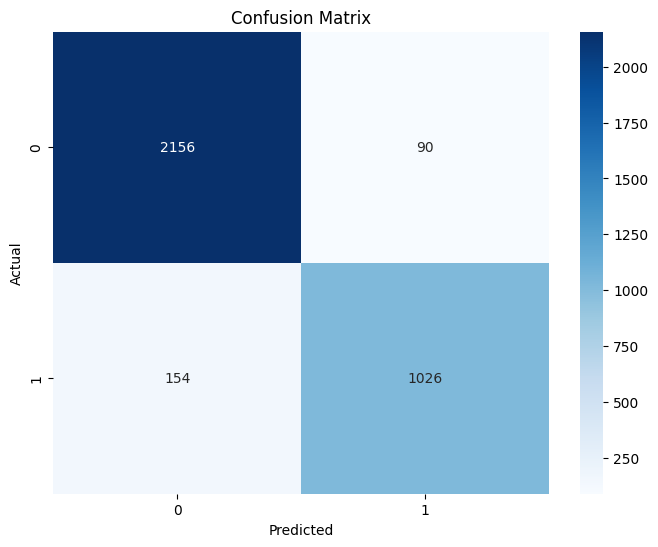

In [77]:
conf_matrix = confusion_matrix(test_y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Explainability

[LightGBM] [Info] Number of positive: 4351, number of negative: 12783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2498
[LightGBM] [Info] Number of data points in the train set: 17134, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.253940 -> initscore=-1.077710
[LightGBM] [Info] Start training from score -1.077710


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


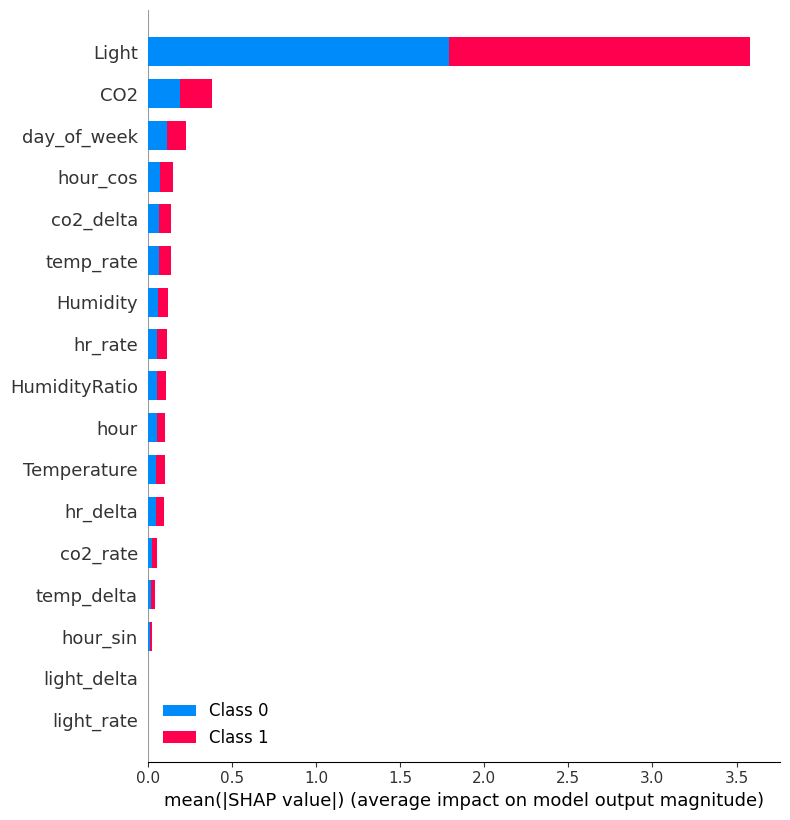

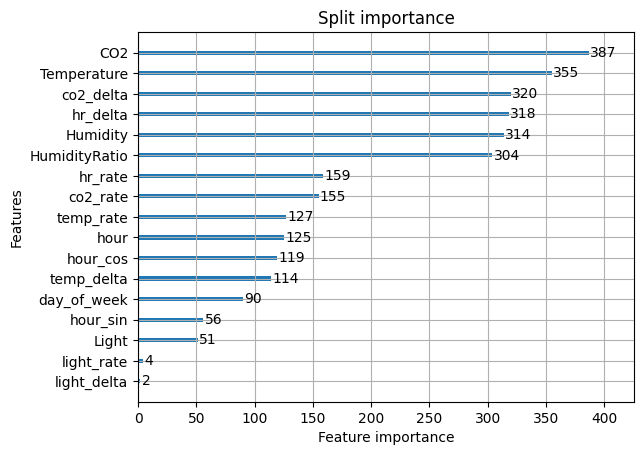

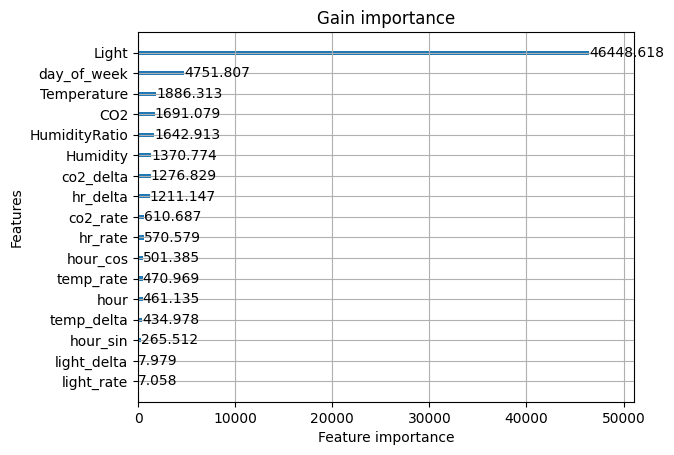

In [ ]:
import shap

# Extract the classifier
classifier_model = pipeline.named_steps['model']
classifier_model.fit(train_X, train_y)

# Initialize the SHAP explainer for the classifier
explainer = shap.TreeExplainer(classifier_model, data=None, model_output='raw', feature_perturbation='tree_path_dependent')

# Get SHAP values (for LightGBM, this returns a list per class)
shap_values = explainer.shap_values(test_X)

shap.summary_plot(shap_values, test_X)
plt.show()

# Plotting feature importance using built-in LightGBM method
import lightgbm as lgb
lgb.plot_importance(classifier_model, importance_type='split')
plt.title("Split importance")
plt.show()

lgb.plot_importance(classifier_model, importance_type='gain')
plt.title("Gain importance")
plt.show()